# Some intro about weak lensing

Weak gravitational lensing is a phenomenon in which the light from distant galaxies is slightly distorted or sheared by the gravitational effects of intervening matter. It provides a powerful tool for probing the distribution of matter in the universe and studying the properties of dark matter and dark energy.

In weak lensing, the gravitational influence of matter along the line of sight causes the apparent shapes of background galaxies to be distorted. This distortion is typically very small, on the order of a few percent or less, and requires statistical analysis of large samples of galaxies to detect and measure accurately.

Excellent review: https://arxiv.org/pdf/1411.0115.pdf

Let's play with some example. At first order, we can describe galaxies as ellipses. 
It is more complicated that this, but it will work fine. 

We can attribute an intrinsic ellipticity $e$ to a galaxy. If we define this quantity for an image with elliptical isophotes, minor-to-major axis ratio $B2D/A2D$, and position angle $\phi$, then $e = (1 − B2D/A2D)/(1 + B2D/A2D) * exp(2i\phi)$. The intrinsic ellipticity can be expressed in terms of the two components, $e_1$ and $e_2$, which are just $e_1 = |e| cos(2\phi)$;  $e_2 = |e| sin(2\phi)$.

Note that these are *projected* (2D) quantities, because we can *observe* only projected images! If you want to simulate the shape of a galaxy, you could also start from 3D ellipsoids.

The intrinsic ellipticities of the galaxies are *sheared* by the shear field, which describes the gravitational influence of matter along the line of sight on the photons of that galaxy. In first approximation, the shear field is described by a spin-2 field $\gamma$. Applying this to the galaxy intrinsic ellipticity, you will obtain:
$e_{1,sheared} \approx  e_{1} +  \gamma_{1}$, $e_{2,sheared} \approx  e_{2} +  \gamma_{2}$

Observational fact: in first approx,
$e_{1},e_{2}  \approx Normal(0,0.3)$ . If you are in the business of simulating shear fields $\gamma$, and you want to add galaxies, you can just add to the shear field a random draw from a Gaussian with zero mean and std ~0.3 to simulate one galaxy.

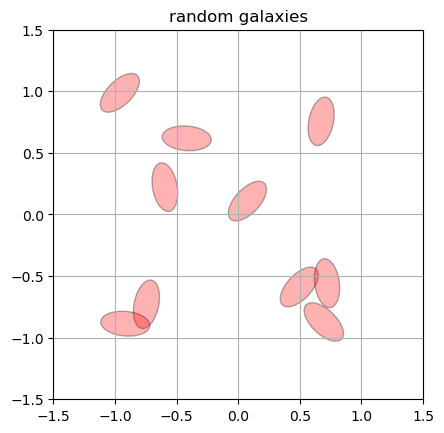

In [1]:
from routines import visualize_ellipse
import numpy as np
import matplotlib.pyplot as plt

# let's create some galaxies.
n_gal = 100000


# let's assume some galaxies
A2d = 0.4*np.ones(n_gal)
B2d = 0.2*np.ones(n_gal)
q = B2d/A2d

#and some random orientation
phi = np.random.rand(n_gal)*2.*np.pi

# compute e1 and e2
e1 = (1-q)/(1+q)* np.cos(2*phi)
e2 = (1-q)/(1+q)* np.sin(2*phi)

# absolute value of the ellipticity
e = np.sqrt(e1**2+e2**2)

# let's give some random coordinates to our galaxies
x = np.random.rand(n_gal)*2-1.
y = np.random.rand(n_gal)*2-1.


fig, ax = plt.subplots()
#plot omly the first 10 galaxies
plt.title('random galaxies')
for i in range(10):
    # only plot galaxies with small ellipticity for visualisation purposes
    if e1[i]**2+e2[i]**2<0.5:
        visualize_ellipse(e1[i], e2[i],x[i],y[i],ax,A2d[i],B2d[i])
plt.show()



/var/folders/02/q9yqytqs0dj5pkpm22vt74zc0000gn/T/ipykernel_63439/550245765.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  e1_new = 500*np.array(shear_fields['e1'])[[x_i,y_i]] + e1
/var/folders/02/q9yqytqs0dj5pkpm22vt74zc0000gn/T/ipykernel_63439/550245765.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  e2_new = 500*np.array(shear_fields['e2'])[[x_i,y_i]] + e2


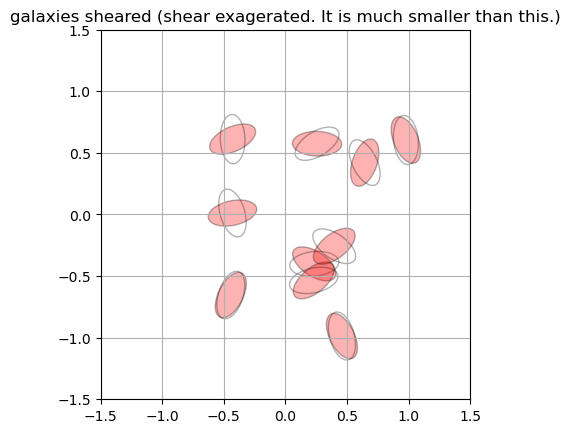

In [2]:
shear_fields = np.load('../data/shear_fields.npy',allow_pickle=True).item()


x_i = np.digitize(y,np.linspace(min(x),max(x),127))
y_i = np.digitize(y,np.linspace(min(y),max(y),127))

e1_new = 500*np.array(shear_fields['e1'])[[x_i,y_i]] + e1
e2_new = 500*np.array(shear_fields['e2'])[[x_i,y_i]] + e2

fig, ax = plt.subplots()

plt.title('galaxies sheared (shear exagerated. It is much smaller than this.)')
for i in range(10):
    # only plot galaxies with small ellipticity for visualisation purposes
    if e1[i]**2+e2[i]**2<0.5:
        visualize_ellipse(e1[i], e2[i],x[i],y[i],ax,A2d[i],B2d[i])
        visualize_ellipse(e1_new[i], e2_new[i],x[i],y[i],ax,A2d[i],B2d[i],color='none')
plt.show()


We infer the shear signal with a variety of tools. One way is to use the 2-point correlation function of galaxy ellipticities, also know as cosmic shear. Cosmic shear has two components, $\xi_+$ and $\xi_-$, because the shear field is a spin-2 quantity. Given two samples of galaxy ellipticity i, j (but they can be the same sample), for every pair of ellipticities, you can compute the tangential component $e_t$ of the ellipticity along the line separating the two galaxies. Similarly, with the cross component $e_x$ (it's on the axis rotated 45 degrees wrt to the tangential line). The cosmic shear estimators are:

$\xi_{+/-} =  \langle e_{t,1},e_{t,2}\rangle \pm \langle e_{x,1},e_{x,2}\rangle$

where the average runs over all the possible galaxy pairs. Usually, it is computed in bings of angular separations. Let's compute that for our simulated sample!

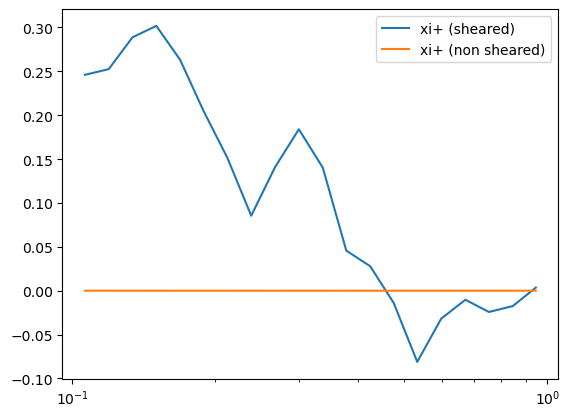

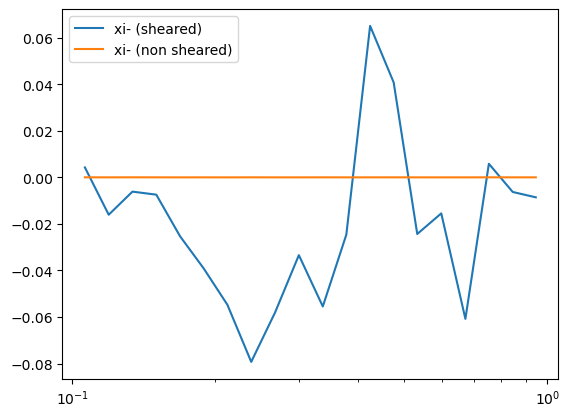

"\nNote! measurements are very noisy because it's a small patch and I am using a coarse pixellisation for the shear maps. \nbut it should give an idea.\n"

In [3]:

import treecorr
cat_shapes_sheared = treecorr.Catalog(x = x, y = y, g1 = e1_new,g2 = e2_new)
cat_shapes_random = treecorr.Catalog(x = x, y = y, g1 = e1,g2 = e2)


gg = treecorr.GGCorrelation(min_sep=0.1, max_sep=1.,nbins= 20)
gg1 = treecorr.GGCorrelation(min_sep=0.1, max_sep=1.,nbins= 20)
gg.process(cat_shapes_random)
xi_p = gg.xip  
xi_m = gg.xim  
gg1.process(cat_shapes_sheared)
xi_p1 = gg1.xip  
xi_m1 = gg1.xim  


plt.plot(gg.meanr,xi_p1,label =  'xi+ (sheared)')
plt.plot(gg.meanr,xi_p,label =  'xi+ (non sheared)')
plt.xscale('log')
plt.legend()
plt.show()



plt.plot(gg.meanr,xi_m1,label =  'xi- (sheared)')
plt.plot(gg.meanr,xi_m,label =  'xi- (non sheared)')

plt.xscale('log')
plt.legend()
plt.show()

'''
Note! measurements are very noisy because it's a small patch and I am using a coarse pixellisation for the shear maps. 
but it should give an idea.
'''

# Some intro about IA

Intrinsic alignment (IA) refers to the correlation or alignment of the shapes or orientations of galaxies on cosmological scales. It arises from physical processes within galaxies themselves, rather than being solely influenced by the large-scale structure of the universe.


You can picture this effect as physically rotating the galaxies, through their angle $\phi$. Or you can also imagine defining a "intrinsic alignment shear field", $\gamma_{IA}$, which we can add to $e_1$ and $e_2$. Both work.

Let's play with rotating physically the galaxies.

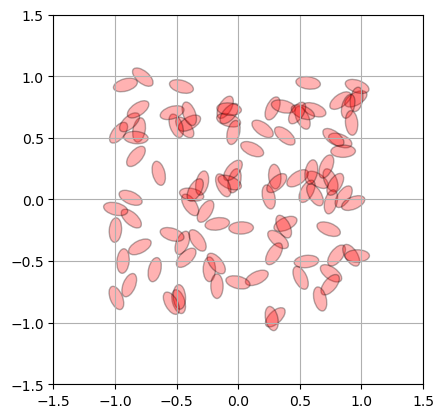

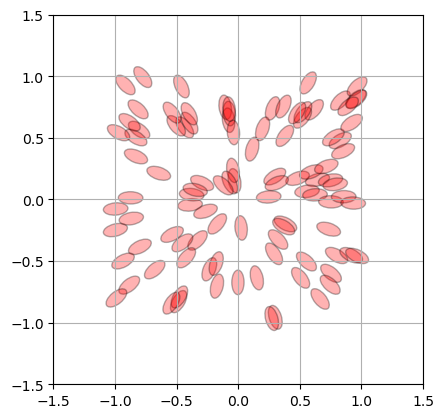

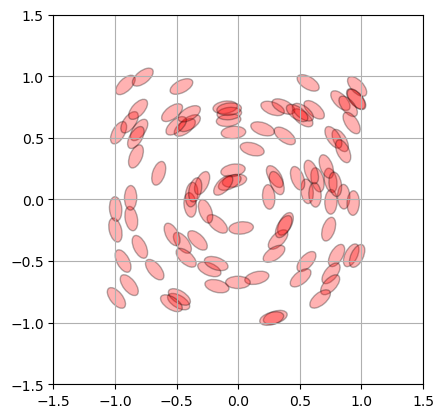

In [211]:
n_gal = 100000

# let's assume some galaxies
A2d = 0.2*np.ones(n_gal)
B2d = 0.1*np.ones(n_gal)
q = B2d/A2d

#and some random orientation
phi = np.random.rand(n_gal)*2.*np.pi

# compute e1 and e2
e1 = (1-q)/(1+q)* np.cos(2*phi)
e2 = (1-q)/(1+q)* np.sin(2*phi)


# absolute value of the ellipticity
e = np.sqrt(e1**2+e2**2)

# let's give some random coordinates to our galaxies
x = np.random.rand(n_gal)*2-1.
y = np.random.rand(n_gal)*2-1.



fig, ax = plt.subplots()
#plot omly the first 100 galaxies
for i in range(100):
    # only plot galaxies with small ellipticity for visualisation purposes
    if e1[i]**2+e2[i]**2<0.5:
        visualize_ellipse(e1[i], e2[i],x[i],y[i],ax,A2d[i],B2d[i])
plt.show()

'''
Ideally, I'd like to orient them. Imagine these are all satellites,
and I want to orient their major axis towards the center.
the 'new orientation' should be:
'''
# center of the halo
x_0 = 0.
y_0 = 0.
#final orientation
phi_final = np.arctan2((y_0-y),(x_0-x))

# phi_final will actually come from the IA model. it will be projected. 
# now you need to rotate e1 and e2 . e1 and e2 transforms
# e1_new = e1 cos(2phi) + e2 sin (2phi)
# e2_new = - e1 sin(2phi) + e2 cos (2phi)

e1_new = +e1 * np.cos(2 * (+phi-phi_final)) + e2 *np.sin (2* (+phi-phi_final))
e2_new = - e1 *np.sin(2* (+phi-phi_final)) + e2 *np.cos (2* (+phi-phi_final))

fig, ax = plt.subplots()
#plot omly the first 100 galaxies
for i in range(100):
    # only plot galaxies with small ellipticity for visualisation purposes
    if e1[i]**2+e2[i]**2<0.5:
        visualize_ellipse(e1_new[i], e2_new[i],x[i],y[i],ax,A2d[i],B2d[i])

        
'''
We can also orient them tangentially to the center!!
'''

e1_new2 = +e1 * np.cos(2 * (+phi-phi_final-np.pi/2.)) + e2 *np.sin (2* (+phi-phi_final-np.pi/2.))
e2_new2 = - e1 *np.sin(2* (+phi-phi_final-np.pi/2.)) + e2 *np.cos (2* (+phi-phi_final-np.pi/2.))




fig, ax = plt.subplots()
#plot omly the first 100 galaxies
for i in range(100):
    # only plot galaxies with small ellipticity for visualisation purposes
    if e1[i]**2+e2[i]**2<0.5:
        visualize_ellipse(e1_new2[i], e2_new2[i],x[i],y[i],ax,A2d[i],B2d[i])



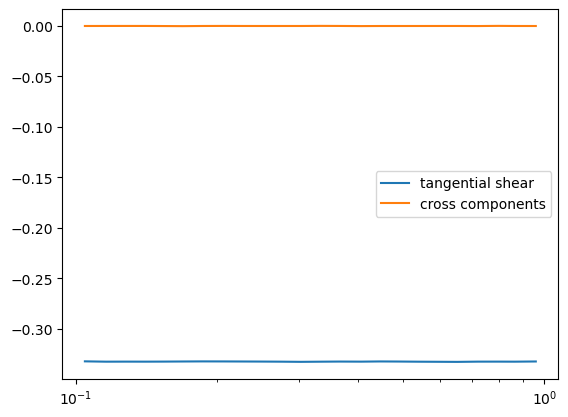

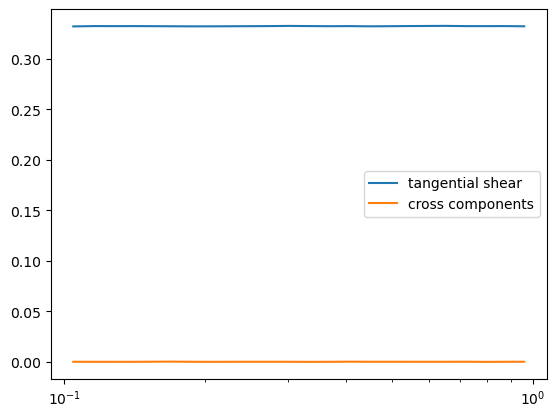

In [35]:
'''
Tangential shear is useful to check if we did everything right.
it can be computed using NGCorrelation from treecorr.
You have two statistics:
 - tangential shear
 - cross components

For radially aligned ellipticitiyes, you should get a negative tangential shear. For tangentially aligned,
you should get a positive shear. The cross ocmponents should always be zero, unless you have a "curly" field.
'''

import treecorr
cat_shapes = treecorr.Catalog(x = x, y = y, g1 = e1_new,g2 = e2_new)
cat_lens = treecorr.Catalog(x = [0], y = [0])


ng = treecorr.NGCorrelation(min_sep=0.1, max_sep=1., bin_size=0.1,
                           )
ng.process(cat_lens,cat_shapes)
xi_t = ng.xi  
xi_x = ng.xi_im  

plt.plot(ng.meanr,xi_t,label =  'tangential shear')
plt.plot(ng.meanr,xi_x,label =  'cross components')
plt.xscale('log')
plt.legend()
plt.show()


import treecorr
cat_shapes = treecorr.Catalog(x = x, y = y, g1 = e1_new2,g2 = e2_new2)
cat_lens = treecorr.Catalog(x = [0], y = [0])


ng = treecorr.NGCorrelation(min_sep=0.1, max_sep=1., bin_size=0.1,
                           )
ng.process(cat_lens,cat_shapes)
xi_t = ng.xi  
xi_x = ng.xi_im  

plt.plot(ng.meanr,xi_t,label =  'tangential shear')
plt.plot(ng.meanr,xi_x,label =  'cross components')
plt.xscale('log')
plt.legend()

# project vectors from 3D onto the sphere

Here we want to learn how to prejects vectors defined in 3D onto a sphere

In [6]:
from modular_alignment import  project_alignments_with_NCP, get_position_angle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


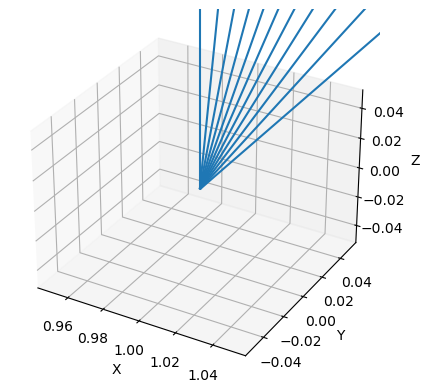

In [141]:
'''
Let's play a bit. Let's define 'coords' as the coordinates of our galaxy.
Let's assume (0,0,0) to be where the observer is located. Let's assume 'major' to specify the
3D vector. 

'''

coords = np.array([[1,0,0]]) # the galaxy is on the x-axis.

# Create a figure and axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

phis = []
# let's rotate the orientation of the galaxy around the x-axis
for x in range(11):
    
    # this basically says that my orientation of the vector starts from (0,1,0) 
    # ( so aligned with the y axis!) and rotates until it's oriented with the z-axis
    # (so (0,0,1)). It's a 90 degrees rotation.
    major = np.array([[0,np.cos(x/10*np.pi/2.),np.sin(x/10*np.pi/2.)]]) 
    
    # Now project onto the plane perpendicular to the line of sight
    # Along with this projection, we will the get vertical and horizontal axes of that plane
    # where vertical is the projection of the North Celestial Pole (NCP) and the horizontal is West

    projected_axes, north, west =  project_alignments_with_NCP( major, coords )

    # Finally, now that we have projected, our 2D orientation can be represented simply 
    # as the position angle taken counterclockwise with
    # respect to the NCP
    phi = get_position_angle(projected_axes)
    ax.quiver(coords[0][0], coords[0][1], coords[0][2], major[0][0], major[0][1], major[0][2])

    
   # print (phi)
# Set the axes labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()


# Map Making

This is something useful. Generally, in data we have catalogs ~ so we work with coordinates. x,y,z (3D cartesian), or in case of photometric surveys, with radial + spherical coordinates (ra,dec, and a measurement of distance, usually redshift z).

From a catalog, you can always make a pixellised map. It is easy with healpy! Imagine you have e1,e2 per galaxy and you want to create a map of e1 and e2 across the sky. you can do it as follows:


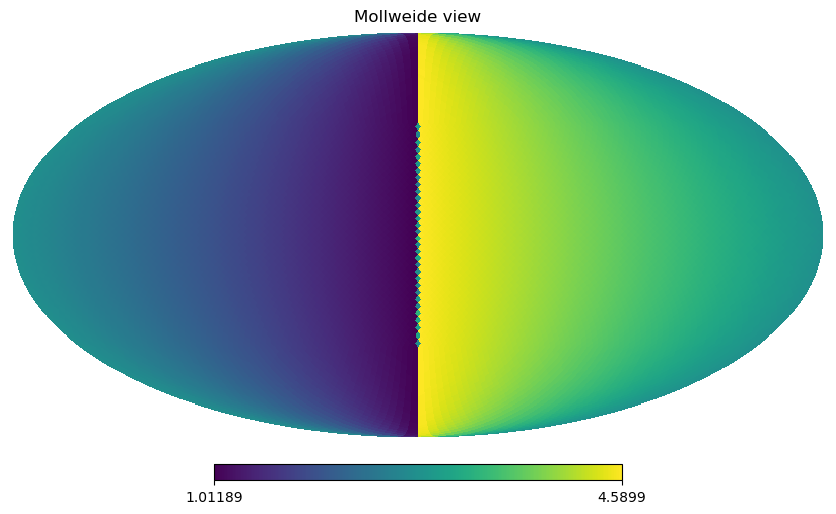

In [39]:
# how to make maps---
# let's assume you have ra,dec, and e1 for all of your galaxies, and you want to make a map of e1.

ra = np.random.rand(1000000)*360
dec = np.random.rand(1000000)*180-90.
# let's make something up just for the sake of plotting something

e1 = ra*0.01+1.
def convert_to_pix_coord(ra, dec, nside=1024):
    """
    Converts RA,DEC to hpix coordinates
    """
    theta = (90.0 - dec) * np.pi / 180.
    phi = ra * np.pi / 180.
    pix = hp.ang2pix(nside, theta, phi, nest=False)
    return pix

nside = 32 # it specifies the resolution of the map.
counts = np.zeros(hp.nside2npix(nside))
e1_map = np.zeros(hp.nside2npix(nside))

pix = convert_to_pix_coord(ra, dec, nside)
unique_pix, idx, idx_rep = np.unique(pix, return_index=True, return_inverse=True) 
counts[unique_pix] += np.bincount(idx_rep, weights=np.ones(len(pix)))
e1_map[unique_pix] += np.bincount(idx_rep, weights=e1)
e1_map[counts!=0] = e1_map[counts!=0] /counts[counts!=0] 
hp.mollview(e1_map)
plt.show()
#hp.mollview(counts)

why is this useful? sometimes simulated products (i.e., density fields or shear fields) come in the format of maps. 
So it's useful to know how to make them. Imagine you have some simulated galaxies, and you want to assign them the ellipticity of a simulated shear field that comes as a map. you can just do



In [ ]:
pix = convert_to_pix_coord(ra, dec, nside)
new_ellipticity = ell_map[pix]

# goal of the project

*goal of the project* :
being able to model IA effects into N-body simulations. There are (mostly) two general ways to do that

- 1st method: Simulating galaxies, and aligning them.
That's what you're trying to do. You start from halo catalogs, you place galaxies, and you (might!) orient them along some preferred directions (halo axis, halo angular mometum, or radially if they're satellites). I'd like you to try to replicate what Nick did. You end up with $e_1$, $e_2$ for each galaxy, and then you can make maps of ellipticities and or compute cosmic shear. What's going to be the strength of the alignment? $|e|$ will be proportional to the intrinsic ellipticity of your galaxy models, the probability of the galaxy being aligned (because it might be different from one), and probably the number density of your galaxies.


- 1st method (version b)
That's what I'd like to do as well ~ remember when I was mentioning we can get an intrinsic alignment shear field without placing galaxies? It's a slight modification of the above. This can be done assuming at every point of the space, $\gamma_{IA,1} = \gamma_{IA} cos(2 \phi), \gamma_{IA,2} = \gamma_{IA} sin (2\phi)$. phi should come from whatever yor trying to align to, and $\gamma_{IA}$ from theory (I can give you that). For instance, you can sample at the center of the halos, and assume $\phi$ to be either the halo major axis or the angular momentum. And $\gamma_{IA}$ will be given by theory considerations. If you sample inside the halo but at not at its center,  $\phi$ will be the radial vector. You basically directly estimate the alginment shear field, without making assumptions about the galaxy shapes (or the HOD, because you sample every point , with some resolution).  Let's keep this for a second moment, and do the 1st method first.



- 2nd method: using density fields.
This is well established. E.g., eq 2.6 https://arxiv.org/pdf/2304.04785.pdf.
The main idea is to start from the matter density field in simulations, $\delta(x,y,z)$, and compute the *alignment field* at every location of the simulations as derivatives of the density field


The second method is already implemented, but it has some limitations. I'd like to implement the first method and see how they compare.


# quick example 1: align satellites around center of the halo

Let's use the halo catalog I provided, and use N halos. let's assume every halo has 10 satellites.

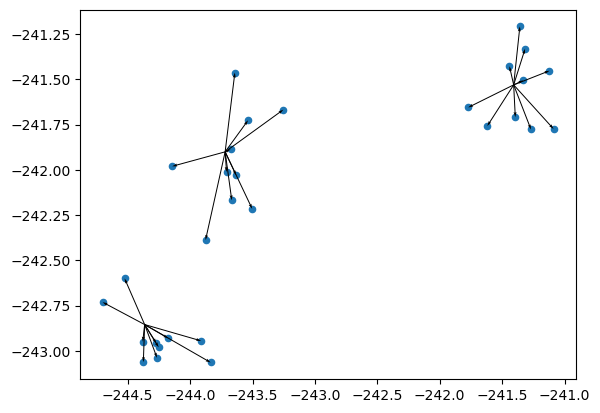

In [4]:
from routines import IndexToDeclRa
import numpy as np
import healpy as hp
halo_cat = np.load('../data/misc.npy',allow_pickle=True)

# get ra,dec
x = halo_cat[0]['x'] - 250.
y = halo_cat[0]['y'] - 250.
z = halo_cat[0]['z'] - 250.

# select the first X -
x_halos = 3
x = x[:x_halos]
y = y[:x_halos]
z = z[:x_halos]

# add satellites
ns = 10
std_ = 0.2
xs = np.array([[ np.random.normal(x[i],std_,1)[0] for i in range(len(x)) ] for j in range(ns)]).flatten()
ys = np.array([[ np.random.normal(y[i],std_,1)[0] for i in range(len(x)) ] for j in range(ns)]).flatten()
zs = np.array([[ np.random.normal(z[i],std_,1)[0] for i in range(len(x)) ] for j in range(ns)]).flatten()

# plot satellites
fig, ax = plt.subplots()

plt.scatter(xs,ys,s=20)

# orient them towards the halo center.
# compute the vector connecting each satellite to their center:
x_halo = np.array([[ x[i] for i in range(len(x)) ] for j in range(ns)]).flatten()
y_halo = np.array([[ y[i] for i in range(len(x)) ] for j in range(ns)]).flatten()
z_halo = np.array([[ z[i] for i in range(len(x)) ] for j in range(ns)]).flatten()

v = np.array([xs-x_halo,ys-y_halo,zs-z_halo])

#plot vectors (they're 3D but we're plotting only the 2D . Note: 2D doesn't mean on the sphere!)
# let's plot the first ones..
ax.quiver(x_halo, y_halo, v[0], v[1], angles='xy', scale_units='xy', scale=1,width=0.002)
plt.show()





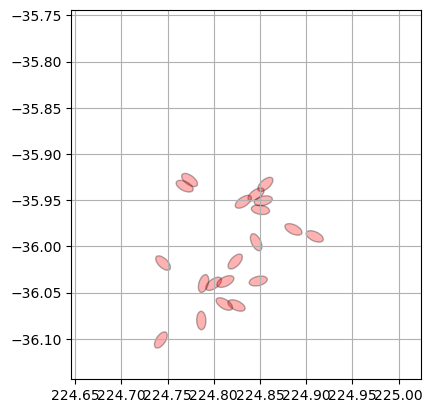

In [15]:
# let's project the vector onto the sphere
projected_axes, north, west =  project_alignments_with_NCP( v.T, np.array([xs,ys,zs]).T )
phi =   - get_position_angle(projected_axes) 
# I added a - sign.  I think it's because of conventions...
    

# let's assume some galaxies
A2d = 0.02*np.ones(len(xs))
B2d = 0.01*np.ones(len(xs))
q = B2d/A2d


# compute e1 and e2
e1 = (1-q)/(1+q)* np.cos(2*phi-np.pi)
e2 = (1-q)/(1+q)* np.sin(2*phi-np.pi)

# let's get ra,dec
index_f = hp.pixelfunc.vec2pix(8192*32, xs,ys,zs)
dec,ra = IndexToDeclRa(index_f,8192*32,nest= False)



   
    
fig, ax = plt.subplots()
#plot omly the first 10 galaxies
for i in range(len(ra)):
    # only plot galaxies with small ellipticity for visualisation purposes
    if e1[i]**2+e2[i]**2<0.5:
        visualize_ellipse(e1[i], e2[i],ra[i],dec[i],ax,A2d[i],B2d[i])

dd = 0.2
ax.set_xlim(ra[0]-dd, ra[1]+dd)
ax.set_ylim(dec[0]-dd,dec[0]+dd)
plt.show()

In [294]:
# redoit but for a lot of galaxies
# get ra,dec
x = halo_cat[0]['x'] - 250.
y = halo_cat[0]['y'] - 250.
z = halo_cat[0]['z'] - 250.


x_halos = 1000
x = x[:x_halos]
y = y[:x_halos]
z = z[:x_halos]

# add satellites
ns = 100
std_ = 1.
xs = np.array([[ np.random.normal(x[i],std_,1)[0] for i in range(len(x)) ] for j in range(ns)]).flatten()
ys = np.array([[ np.random.normal(y[i],std_,1)[0] for i in range(len(x)) ] for j in range(ns)]).flatten()
zs = np.array([[ np.random.normal(z[i],std_,1)[0] for i in range(len(x)) ] for j in range(ns)]).flatten()

# orient them towards the halo center.
# compute the vector connecting each satellite to their center:
x_halo = np.array([[ x[i] for i in range(len(x)) ] for j in range(ns)]).flatten()
y_halo = np.array([[ y[i] for i in range(len(x)) ] for j in range(ns)]).flatten()
z_halo = np.array([[ z[i] for i in range(len(x)) ] for j in range(ns)]).flatten()

v = np.array([xs-x_halo,ys-y_halo,zs-z_halo])


# let's project the vector onto the sphere
projected_axes, north, west =  project_alignments_with_NCP( v.T, np.array([xs,ys,zs]).T )
phi =   - get_position_angle(projected_axes) 
# I added a - sign.  I think it's because of conventions...
    

# let's assume some galaxies
A2d = 0.02*np.ones(len(xs))
B2d = 0.01*np.ones(len(xs))
q = B2d/A2d


# compute e1 and e2
e1 = (1-q)/(1+q)* np.cos(2*phi-np.pi)
e2 = (1-q)/(1+q)* np.sin(2*phi-np.pi)

# let's get ra,dec
index_f = hp.pixelfunc.vec2pix(8192*32, xs,ys,zs)
dec,ra = IndexToDeclRa(index_f,8192*32,nest= False)



    

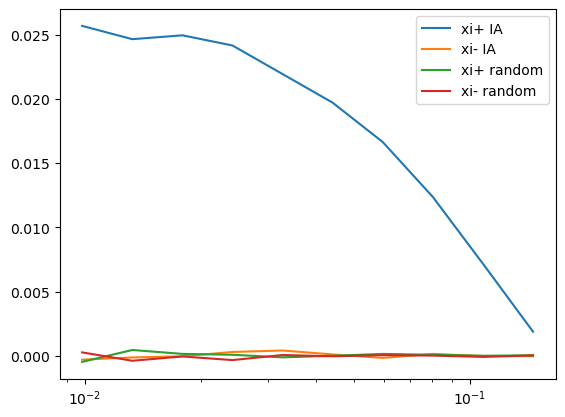

In [297]:
#and some random orientation (you should get the 'phi' from projecting the anular momentum vector onto the sphere.)
phi = np.random.rand(len(phi))*2.*np.pi

# compute e1 and e2
e1_random = (1-q)/(1+q)* np.cos(2*phi)
e2_random = (1-q)/(1+q)* np.sin(2*phi)


# let's measure cosmic shear. If you orient things correctly, you'll see a signal. Now it's all random.

import treecorr

Nbins = 10

min_theta = 0.5/60.
max_theta = 10./60.
number_of_cores = 2
bin_slope = 0.1


conf = {'nbins': Nbins,
            'min_sep': min_theta,
            'max_sep': max_theta,
            'sep_units': 'degrees',
            'bin_slop': bin_slope,
            'nodes': number_of_cores  # parameter for treecorr
            }

cat_shapes = treecorr.Catalog(ra = ra, dec = dec, g1 = e1,g2 = e2,ra_units='deg', dec_units='deg',)
cat_shapes_random = treecorr.Catalog(ra = ra, dec = dec, g1 = e1_random,g2 = e2_random,ra_units='deg', dec_units='deg',)


gg = treecorr.GGCorrelation(conf)
gg1 = treecorr.GGCorrelation(conf)
gg.process(cat_shapes)
xi_p = gg.xip  
xi_m = gg.xim  

gg1.process(cat_shapes_random)
xi_p1 = gg1.xip  
xi_m1 = gg1.xim  


plt.plot(gg.meanr,xi_p,label =  'xi+ IA')
plt.plot(gg.meanr,xi_m,label =  'xi- IA')
plt.plot(gg.meanr,xi_p1,label =  'xi+ random')
plt.plot(gg.meanr,xi_m1,label =  'xi- random')
plt.xscale('log')
plt.legend()
plt.show()

# todo

- do it for central galaxies, aligned with the major axis of the halos, and with the angular mometum of the halo.
- include Nick's routines, which includes some elements of randomness in the orientation.



In [ ]:
central_alignment_strength = 0.8
satellite_alignment_strength=0.5


# Don't forget to use the proper mask
# This way, we are only passing in the values needed for aligning the centrals or satellites
cen_major, cen_inter, cen_minor = align_to_halo( halo_axisA_x[central_mask], halo_axisA_y[central_mask], halo_axisA_z[central_mask],
                                                 central_alignment_strength, prim_gal_axis="A" )

sat_major, sat_inter, sat_minor = align_radially( halo_x[~central_mask], halo_y[~central_mask], halo_z[~central_mask], 
                                                     x[~central_mask], y[~central_mask], z[~central_mask], 
                                                     Lbox, satellite_alignment_strength, prim_gal_axis="A" )